In [7]:
### Importamos la librería necesaria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

# Configurar el nivel de registro de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = todos los mensajes, 1 = advertencias, 2 = errores, 3 = críticos

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Librería XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [8]:
# Leemos los csv con los datos de entrenamiento
ruta_train = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_todas_train.csv"
df = pd.read_csv(ruta_train, sep=';', decimal='.')

# Leemos los csv con los datos de prueba
ruta_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_todas_prueba.csv"
df_prueba = pd.read_csv(ruta_prueba, sep=';', decimal='.')

In [9]:
# Mostramos los primeros datos
df.head()

,fecha,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,intensidad,ocupacion,carga,vmed,TEMPERATURA,PRECIPITACION,FESTIVO
0,2023-01-01 00:00:00,2023,1,1,0,0,6,192.00,1.16,6.93,69.69,7.6,0.0,0.0
1,2023-01-01 00:15:00,2023,1,1,0,15,6,164.73,0.75,5.65,65.35,7.6,0.0,0.0
2,2023-01-01 00:30:00,2023,1,1,0,30,6,635.38,1.58,20.05,74.82,7.6,0.0,0.0
3,2023-01-01 00:45:00,2023,1,1,0,45,6,1234.29,5.05,38.98,72.51,7.6,0.0,0.0
4,2023-01-01 01:00:00,2023,1,1,1,0,6,1701.24,8.20,52.78,68.58,7.5,0.0,0.0


In [10]:
# Mostramos los primeros datos
df_prueba.head()

,fecha,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,intensidad,ocupacion,carga,vmed,TEMPERATURA,PRECIPITACION,FESTIVO
0,2024-01-01 00:00:00,2024,1,1,0,0,0,198.02,0.78,6.56,69.64,6.5,0.0,1.0
1,2024-01-01 00:15:00,2024,1,1,0,15,0,178.85,0.44,5.89,64.53,6.5,0.0,1.0
2,2024-01-01 00:30:00,2024,1,1,0,30,0,666.07,1.84,21.56,74.09,6.5,0.0,1.0
3,2024-01-01 00:45:00,2024,1,1,0,45,0,1269.45,5.25,40.07,71.13,6.5,0.0,1.0
4,2024-01-01 01:00:00,2024,1,1,1,0,0,1691.75,7.75,52.76,68.56,6.3,0.0,1.0


In [11]:
# Nos aseguramos que la columna 'fecha' esté en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df_prueba['fecha'] = pd.to_datetime(df_prueba['fecha'])

# Seleccionamos las columnas relevantes para el modelo
feature_cols = ['intensidad', 'ocupacion', 'carga', 'vmed', 'HORA', 'DIA_SEMANA', 'TEMPERATURA', 'FESTIVO']
df_encoded = df[feature_cols]
df_encoded_prueba = df_prueba[feature_cols]


# Escalamos las características numéricas
scaler = StandardScaler()
df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])
df_encoded_prueba[feature_cols] = scaler.fit_transform(df_encoded_prueba[feature_cols])

# Creamos las secuencias para el modelo
window_size = 100  # 1 día (96 intervalos de 15 minutos)
n_features = len(feature_cols)

forecast_steps = 4  # Número de pasos a predecir
X = []
y = []

for i in range(window_size, len(df) - forecast_steps + 1):
    X.append(df_encoded.iloc[i-window_size:i].values)
    y.append(df_encoded.iloc[i:i+forecast_steps]['intensidad'].values)

X = np.array(X)
y = np.array(y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_prueba = []
y_prueba = []

# Operamos ahora con los datos de prueba
for i in range(window_size, len(df_prueba) - forecast_steps + 1):
    X_prueba.append(df_encoded_prueba.iloc[i-window_size:i].values)
    y_prueba.append(df_encoded_prueba.iloc[i:i+forecast_steps]['intensidad'].values)

X_prueba = np.array(X_prueba)
y_prueba = np.array(y_prueba)

/tmp/ipykernel_284211/3652465113.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[feature_cols] = scaler.fit_transform(df_encoded[feature_cols])
/tmp/ipykernel_284211/3652465113.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_prueba[feature_cols] = scaler.fit_transform(df_encoded_prueba[feature_cols])


In [13]:
# Definir modelo base para CPU
xgb_model = XGBRegressor(tree_method='hist', device='cpu', random_state=42, n_jobs=1)

# Aplanamos los datos de entrenamiento para que puedan ser procesados por el modelo
n_samples, timesteps, features = X_train.shape
X_train_flat = X_train.reshape(n_samples, timesteps * features)


# Hiperparámetros para optimización
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Callback para liberar memoria (CPU)
def clear_memory():
    """Fuerza la recolección de basura en la CPU."""
    gc.collect()

# Clase personalizada para RandomizedSearchCV
class CustomRandomSearchCV(RandomizedSearchCV):
    def _fit(self, X, y, groups, parameter_iterable):
        for parameters in parameter_iterable:
            print(f"Entrenando con parámetros: {parameters}")
            try:
                # Llama al método _fit original para cada conjunto de parámetros
                super(CustomRandomSearchCV, self)._fit(X, y, groups, [parameters])
            except Exception as e:
                print(f"Error durante el entrenamiento con parámetros {parameters}: {e}")
            finally:
                # Liberar memoria de CPU
                clear_memory()

# Búsqueda aleatoria de hiperparámetros
random_search = CustomRandomSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=15,
    cv=2,
    verbose=2,
    random_state=42
)

# Entrenamos la búsqueda
try:
    random_search.fit(X_train_flat, y_train)
except Exception as e:
    print(f"Error durante la búsqueda: {e}")

# Mejor modelo y parámetros
if hasattr(random_search, 'best_estimator_'):
    best_xgb_model = random_search.best_estimator_
    print("Mejores hiperparámetros:")
    print(random_search.best_params_)
else:
    print("No se encontraron parámetros óptimos debido a errores.")

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time= 3.6min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.8; total time= 3.5min
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time= 1.3min
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time= 1.4min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.6; total time= 2.3min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.6; total time= 2.4min
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.6; total time= 3.0min
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.6; total time= 2.9min
[CV] END colsam

In [14]:
# Aplanamos los datos de entrenamiento para que puedan ser procesados por el modelo
n_samples, timesteps, features = X_test.shape
X_test_flat = X_test.reshape(n_samples, timesteps * features)

# Predicciones
y_pred = best_xgb_model.predict(X_test_flat)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_test), len(feature_cols))), columns=feature_cols)

# Paso 1 (15 minutos)
df_reconstructed['intensidad'] = y_test[:, 0]
y_test_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_test[:, 1]
y_test_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_test[:, 2]
y_test_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_test[:, 3]
y_test_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_test[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_test[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_test[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_test[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_test[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_test[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_test[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_test[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

Paso 1 - MAE: 0.044998907510429766, MSE: 0.0038665855634592017, RMSE: 0.062181874878932376, R-squared: 0.9961621940674292
Paso 2 - MAE: 0.055658724116278854, MSE: 0.006135239596697535, RMSE: 0.07832777027783655, R-squared: 0.9938980316475962
Paso 3 - MAE: 0.0622192867079237, MSE: 0.007938191686332382, RMSE: 0.08909653015876871, R-squared: 0.9921053374299212
Paso 4 - MAE: 0.06513634505893637, MSE: 0.008670414450113212, RMSE: 0.09311506027551726, R-squared: 0.9913705988583054


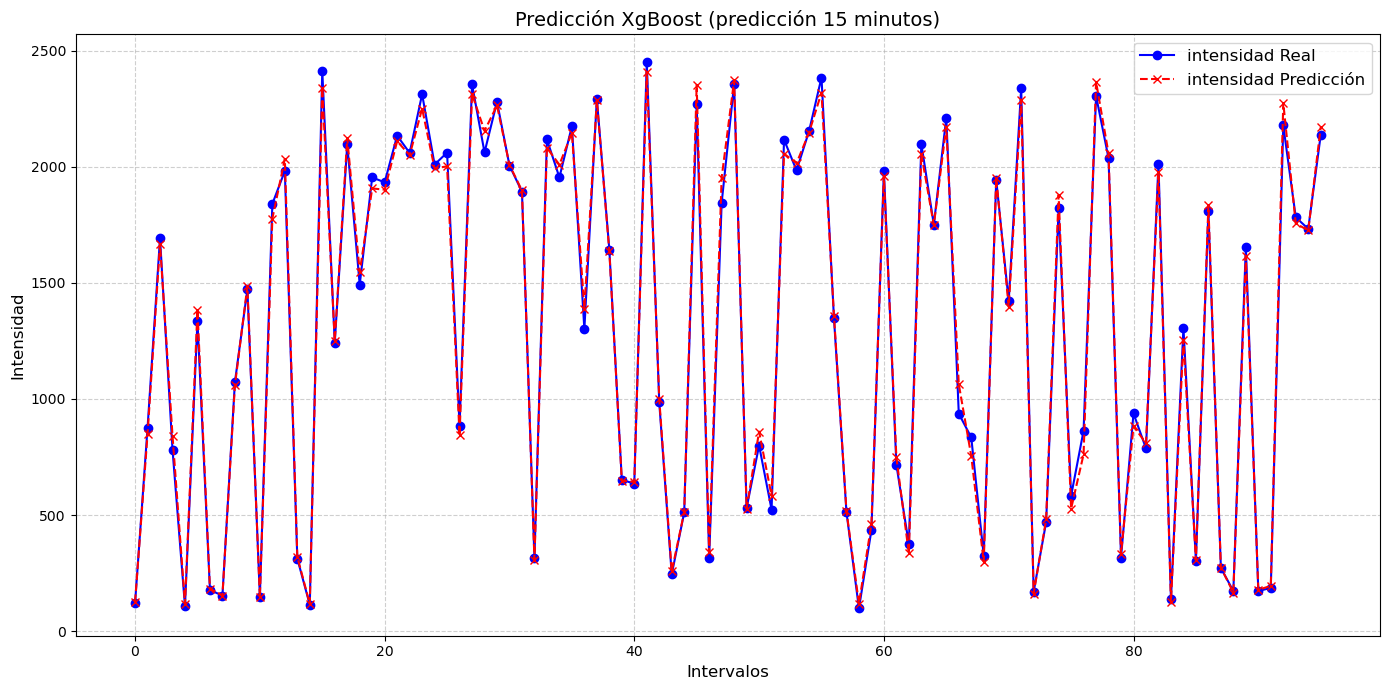

In [15]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XgBoost (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

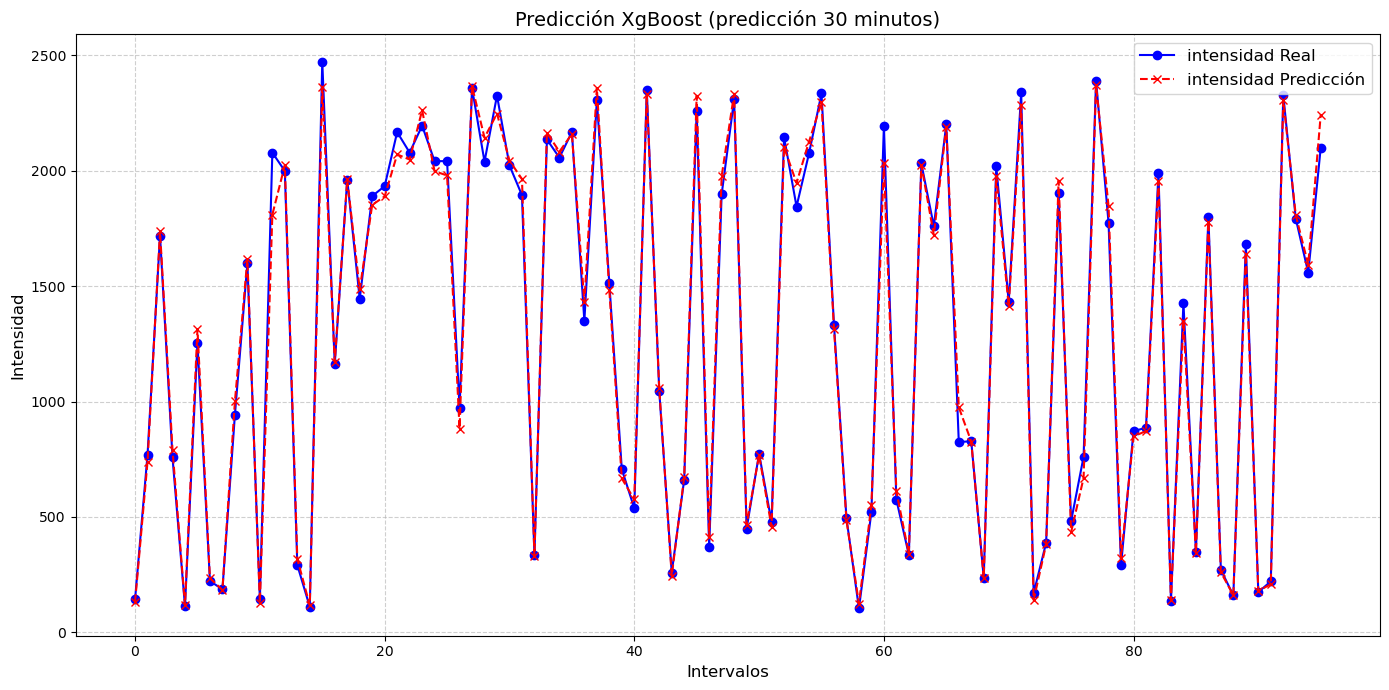

In [16]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step2[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step2[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XgBoost (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

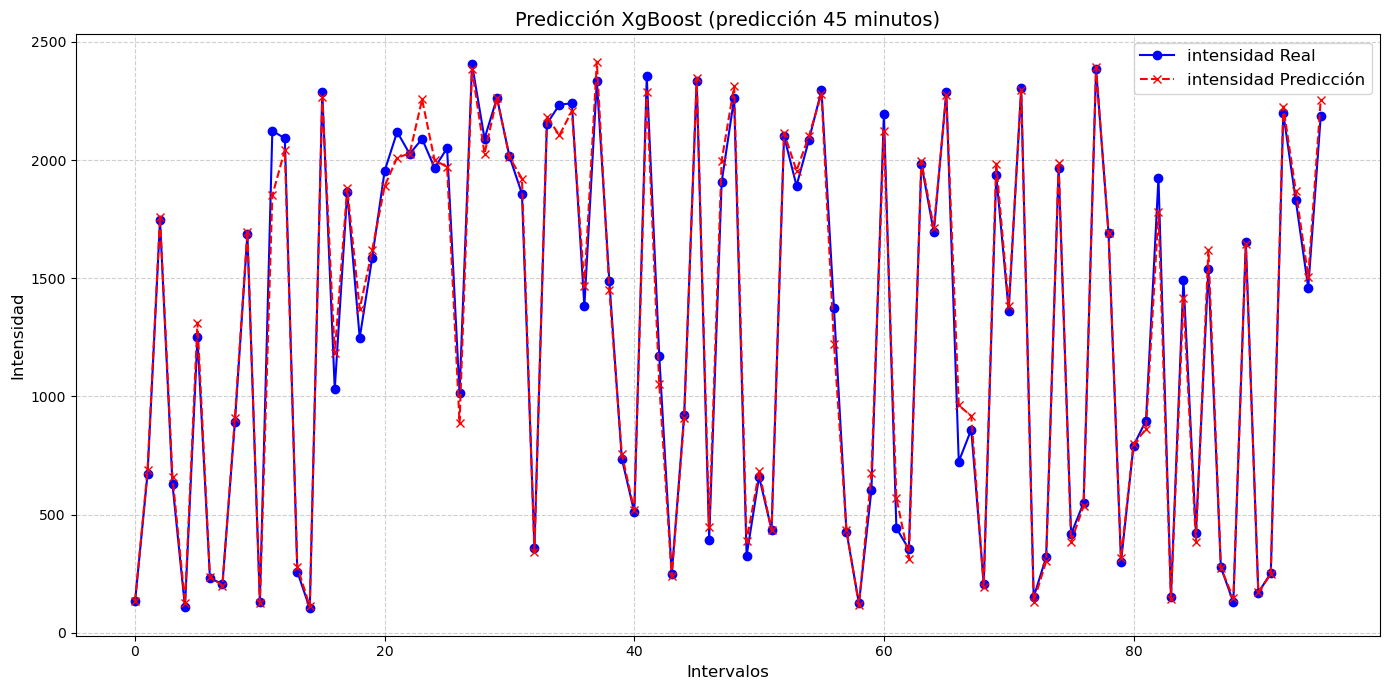

In [17]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step3[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step3[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XgBoost (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

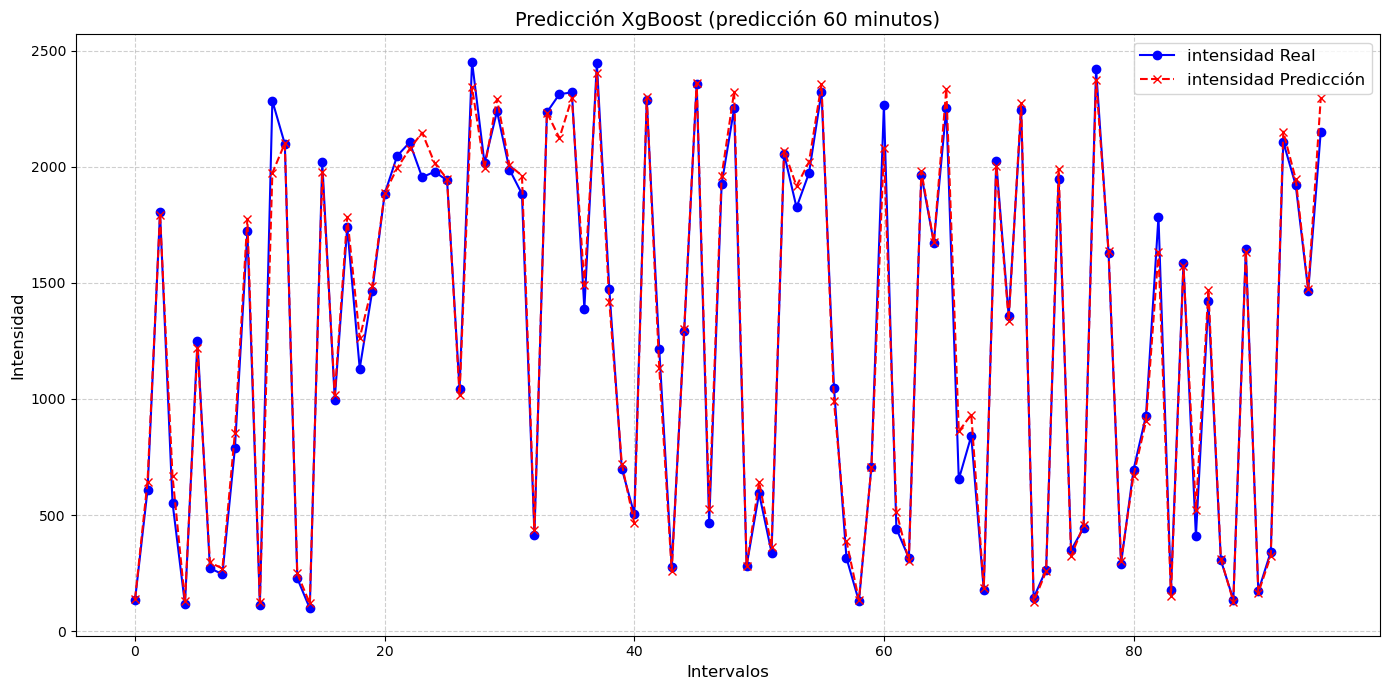

In [18]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_test_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XgBoost (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Guardamos el modelo creado

In [19]:
# Ruta para guardar el modelo
ruta_modelo = '/mnt/c/Users/migue/Documents/Python/UNIR/TFE/Todas estaciones/best_xgb_model.pkl'

# Guardamos el modelo
joblib.dump(best_xgb_model, ruta_modelo)

print(f"Modelo guardado en {ruta_modelo}")

Modelo guardado en /mnt/c/Users/migue/Documents/Python/UNIR/TFE/Todas estaciones/best_xgb_model.pkl


## Validación con un conjunto de datos no visto por el modelo

In [20]:
# Aplanamos los datos de entrenamiento para que puedan ser procesados por el modelo
n_samples, timesteps, features = X_prueba.shape
X_prueba_flat = X_prueba.reshape(n_samples, timesteps * features)

# Predicciones
y_pred = best_xgb_model.predict(X_prueba_flat)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_prueba), len(feature_cols))), columns=feature_cols)

# Paso 1 (primer intervalo)
df_reconstructed['intensidad'] = y_prueba[:, 0]
y_prueba_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 1]
y_prueba_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 2]
y_prueba_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_prueba[:, 3]
y_prueba_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_prueba[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_prueba[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_prueba[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_prueba[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_prueba[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_prueba[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_prueba[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_prueba[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_prueba[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_prueba[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_prueba[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_prueba[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

Paso 1 - MAE: 0.04316871104880966, MSE: 0.0036108909816835876, RMSE: 0.06009068964226977, R-squared: 0.9963987226913507
Paso 2 - MAE: 0.05615514840218607, MSE: 0.0063009195561658515, RMSE: 0.0793783317799376, R-squared: 0.9937144871897577
Paso 3 - MAE: 0.06445136449038263, MSE: 0.008555507288522694, RMSE: 0.09249598525624068, R-squared: 0.9914633742764215
Paso 4 - MAE: 0.06936751200686701, MSE: 0.010154745958917124, RMSE: 0.10077075944398317, R-squared: 0.9898652689812847


#### Gráficas

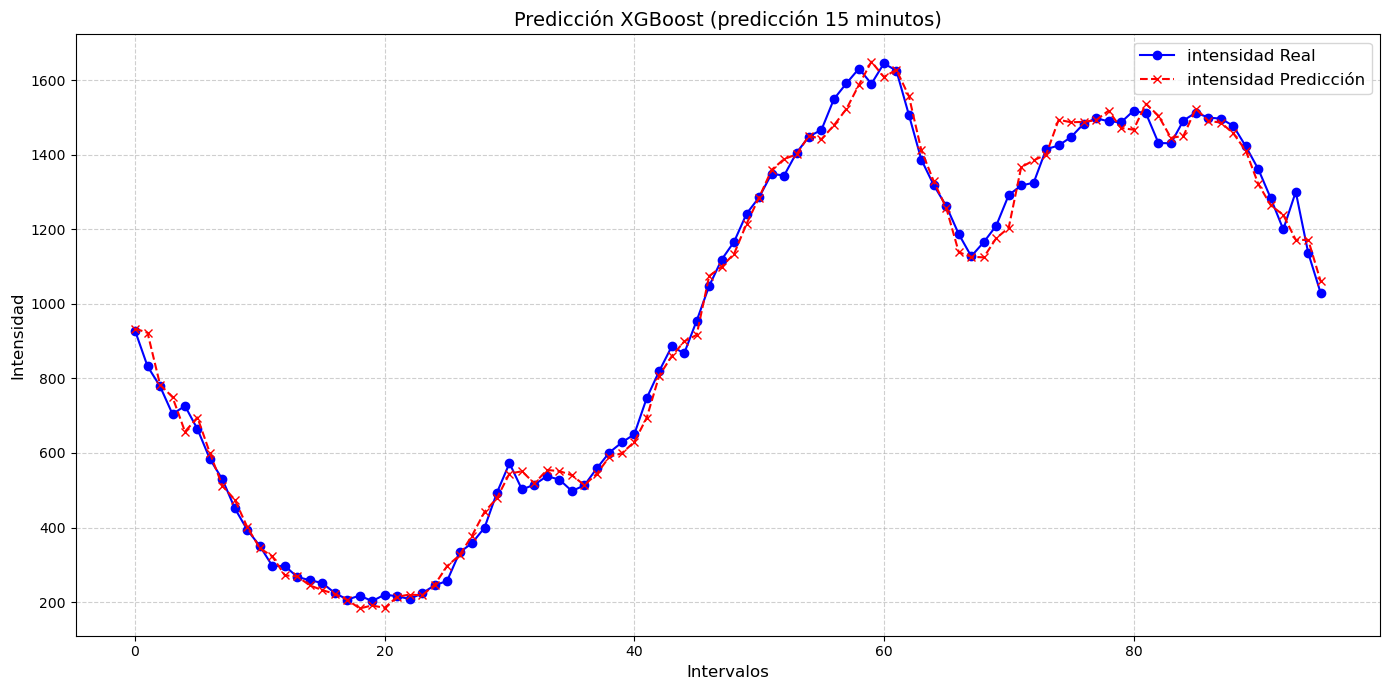

In [21]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XGBoost (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

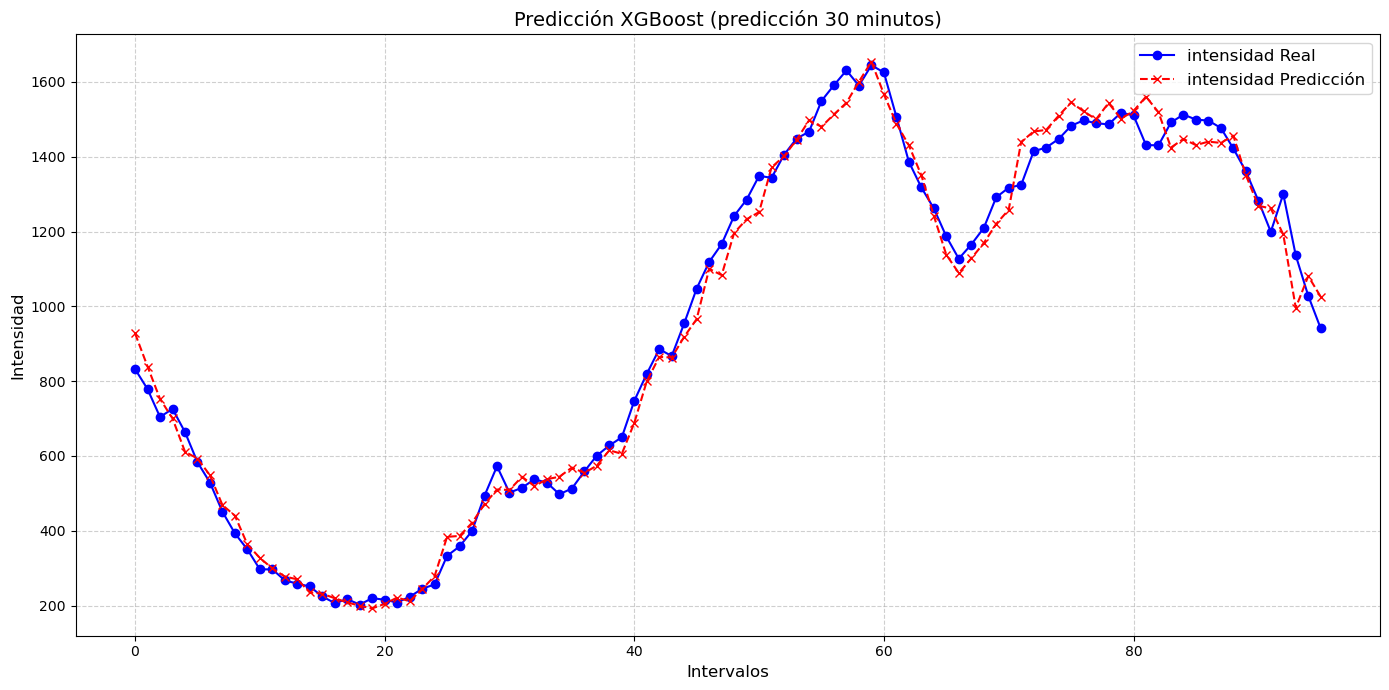

In [22]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step2[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step2[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XGBoost (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

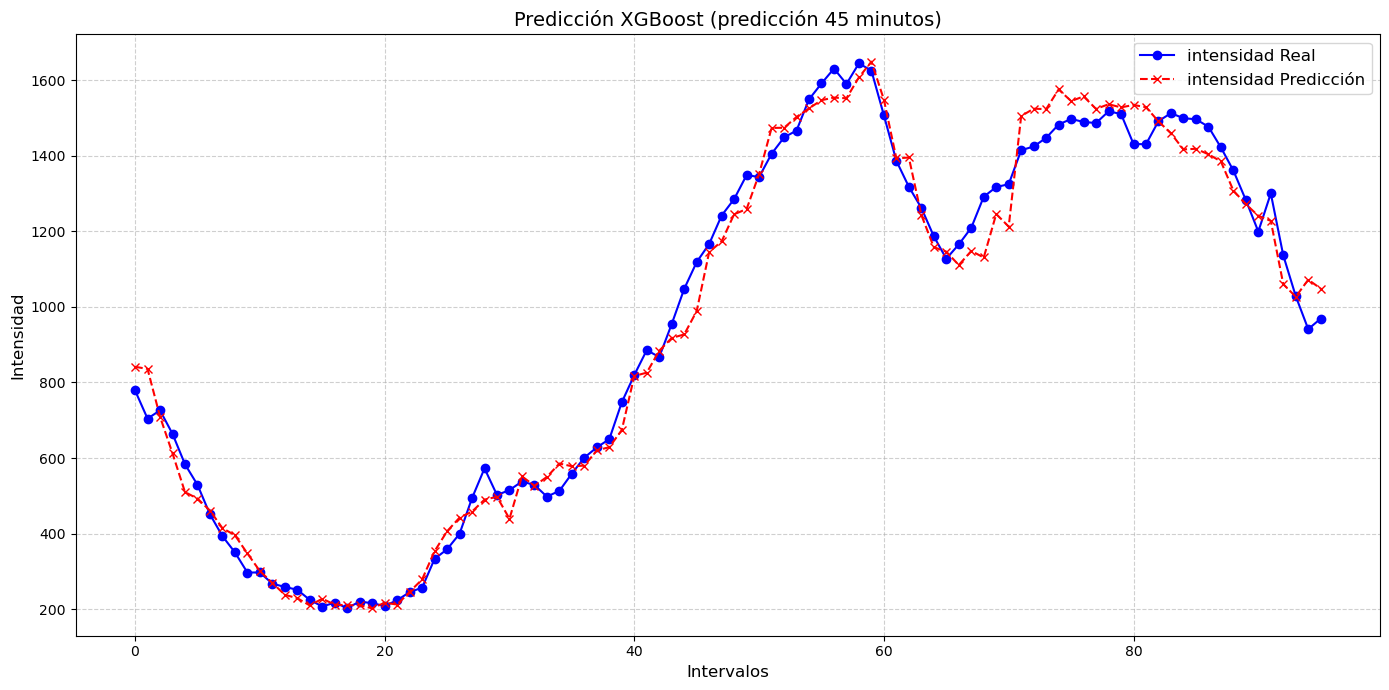

In [23]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step3[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step3[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XGBoost (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

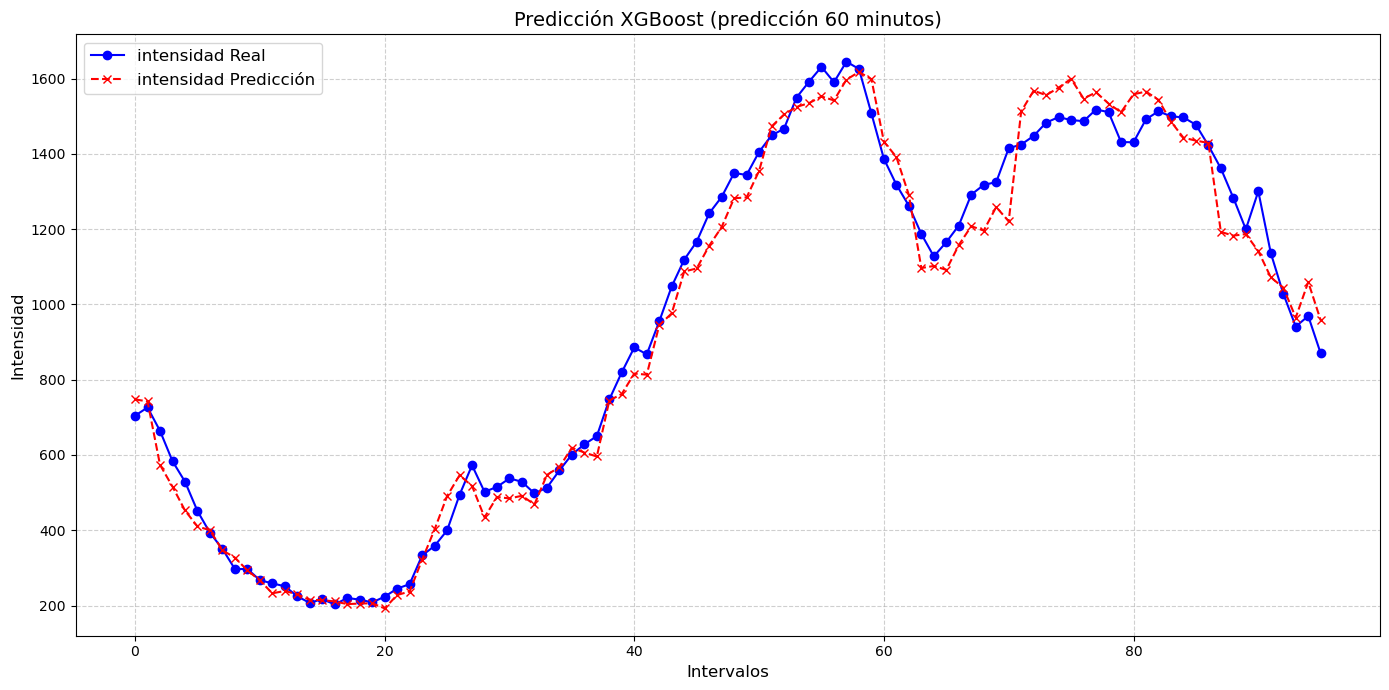

In [24]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_prueba_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XGBoost (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Prueba una única estación  
Probamos el modelo sobre la estación 3490 (Km 10.8 de la M-30).

In [25]:
# Leemos los csv con los datos de entrenamiento
ruta_estacion_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_estacion = pd.read_csv(ruta_estacion_prueba, sep=';', decimal='.')

# Creamos el conjunto con los datos de la estación 3490
datos_3490 = df_estacion[df_estacion['id'] == 3490]

In [26]:
# Preparamos los datos de la estación
# Nos aseguramos que la columna 'fecha' esté en formato datetime
datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])

# Seleccionamos las columnas relevantes para el modelo
df_encoded_3490 = datos_3490[feature_cols]


# Escalamos las características numéricas
scaler = StandardScaler()
df_encoded_3490[feature_cols] = scaler.fit_transform(df_encoded_3490[feature_cols])


X_3490 = []
y_3490 = []

# Operamos ahora con los datos de prueba
for i in range(window_size, len(datos_3490) - forecast_steps + 1):
    X_3490.append(df_encoded_3490.iloc[i-window_size:i].values)
    y_3490.append(df_encoded_3490.iloc[i:i+forecast_steps]['intensidad'].values)

X_3490 = np.array(X_3490)
y_3490 = np.array(y_3490)

/tmp/ipykernel_284211/942581670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])
/tmp/ipykernel_284211/942581670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded_3490[feature_cols] = scaler.fit_transform(df_encoded_3490[feature_cols])


In [27]:
# Aplanamos los datos de entrenamiento para que puedan ser procesados por el modelo
n_samples, timesteps, features = X_3490.shape
X_3490_flat = X_3490.reshape(n_samples, timesteps * features)

# Predicciones
y_pred = best_xgb_model.predict(X_3490_flat)

# Reconstrucción y desescalado para cada paso
df_reconstructed = pd.DataFrame(np.zeros((len(y_3490), len(feature_cols))), columns=feature_cols)

# Paso 1 (primer intervalo)
df_reconstructed['intensidad'] = y_3490[:, 0]
y_3490_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 0]
y_pred_original_step1 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 2 (30 minutos)
df_reconstructed['intensidad'] = y_3490[:, 1]
y_3490_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 1]
y_pred_original_step2 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 3 (45 minutos)
df_reconstructed['intensidad'] = y_3490[:, 2]
y_3490_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 2]
y_pred_original_step3 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Paso 4 (60 minutos)
df_reconstructed['intensidad'] = y_3490[:, 3]
y_3490_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

df_reconstructed['intensidad'] = y_pred[:, 3]
y_pred_original_step4 = scaler.inverse_transform(df_reconstructed)[:, feature_cols.index('intensidad')]

# Cálculo de métricas para el Paso 1
mae_step1 = mean_absolute_error(y_3490[:, 0], y_pred[:, 0])
mse_step1 = mean_squared_error(y_3490[:, 0], y_pred[:, 0])
rmse_step1 = np.sqrt(mse_step1)
r2_step1 = r2_score(y_3490[:, 0], y_pred[:, 0])

# Cálculo de métricas para el Paso 2
mae_step2 = mean_absolute_error(y_3490[:, 1], y_pred[:, 1])
mse_step2 = mean_squared_error(y_3490[:, 1], y_pred[:, 1])
rmse_step2 = np.sqrt(mse_step2)
r2_step2 = r2_score(y_3490[:, 1], y_pred[:, 1])

# Cálculo de métricas para el Paso 3
mae_step3 = mean_absolute_error(y_3490[:, 2], y_pred[:, 2])
mse_step3 = mean_squared_error(y_3490[:, 2], y_pred[:, 2])
rmse_step3 = np.sqrt(mse_step3)
r2_step3 = r2_score(y_3490[:, 2], y_pred[:, 2])

# Cálculo de métricas para el Paso 4
mae_step4 = mean_absolute_error(y_3490[:, 3], y_pred[:, 3])
mse_step4 = mean_squared_error(y_3490[:, 3], y_pred[:, 3])
rmse_step4 = np.sqrt(mse_step4)
r2_step4 = r2_score(y_3490[:, 3], y_pred[:, 3])

print(f"Paso 1 - MAE: {mae_step1}, MSE: {mse_step1}, RMSE: {rmse_step1}, R-squared: {r2_step1}")
print(f"Paso 2 - MAE: {mae_step2}, MSE: {mse_step2}, RMSE: {rmse_step2}, R-squared: {r2_step2}")
print(f"Paso 3 - MAE: {mae_step3}, MSE: {mse_step3}, RMSE: {rmse_step3}, R-squared: {r2_step3}")
print(f"Paso 4 - MAE: {mae_step4}, MSE: {mse_step4}, RMSE: {rmse_step4}, R-squared: {r2_step4}")

Paso 1 - MAE: 0.1361196761215096, MSE: 0.05274600507165784, RMSE: 0.2296649844265726, R-squared: 0.9474285659372105
Paso 2 - MAE: 0.16479564955637324, MSE: 0.07222231704715759, RMSE: 0.26874210136701243, R-squared: 0.9280009869911023
Paso 3 - MAE: 0.17833038660361172, MSE: 0.07768604676816201, RMSE: 0.2787221677013904, R-squared: 0.9225350922306855
Paso 4 - MAE: 0.18751196972589584, MSE: 0.08229597052029022, RMSE: 0.2868727427280086, R-squared: 0.9179184981053651


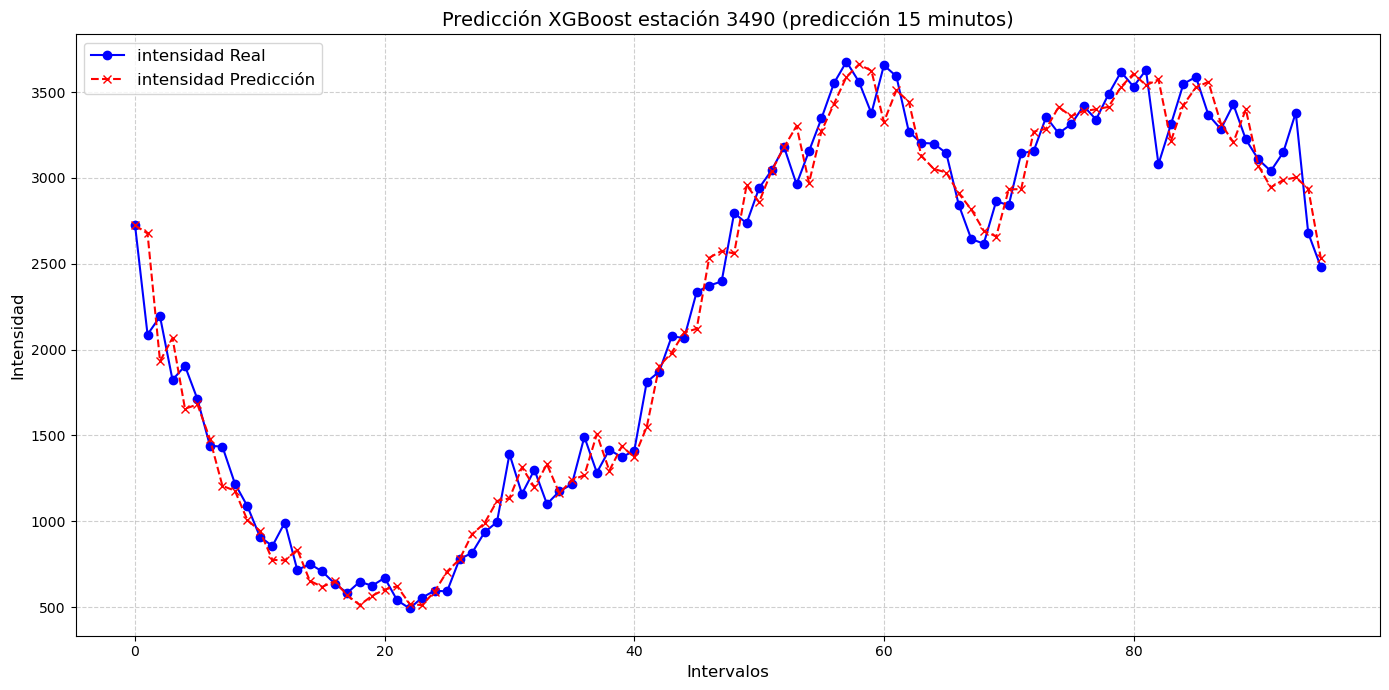

In [28]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_3490_original_step1[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step1[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XGBoost estación 3490 (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

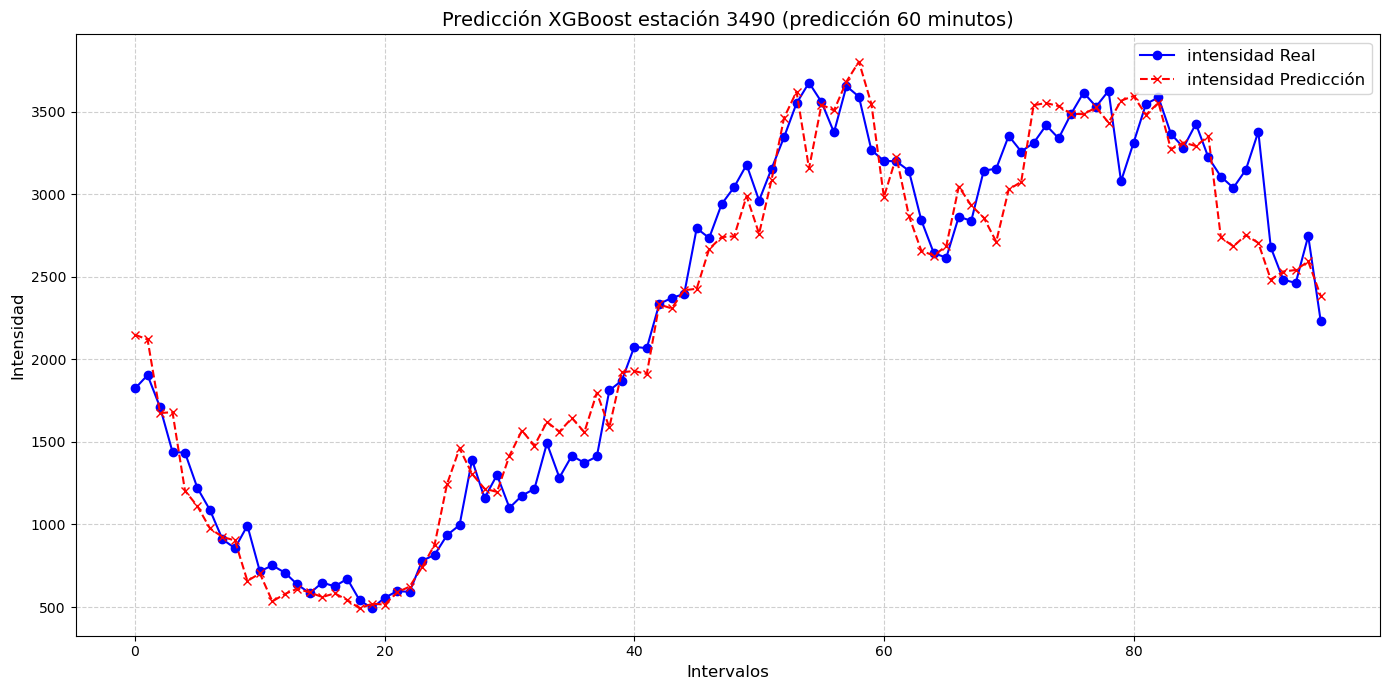

In [29]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos
plt.plot(y_3490_original_step4[-96:], label='intensidad Real', color='blue', marker='o', linestyle='-')
plt.plot(y_pred_original_step4[-96:], label='intensidad Predicción', color='red', marker='x', linestyle='--')

plt.title('Predicción XGBoost estación 3490 (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()